#### 00) Importing libraries 

In [49]:
import numpy as np; import pandas as pd; import scipy; import math; import random; from statistics import mean
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
import joblib
from matplotlib import pyplot as plt 
import tensorflow as tf
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM 
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
import prince; from prince import MCA
from prince import FAMD
%matplotlib inline

## **Individual Health-Based Insurance Premium Forecast.**

### Objective of the Project: 

The purposes of this exercise to look into different features to observe their relationship to existing medical **expense**, and plot a multiple linear regression based on several features of individual such as: 
- Age 
- Sex 
- BMI 
- Children 
- Location 
- Smoking Habits

This relationship will be helpful to predict **future medical expenses** of individuals that help medical insurance to make decision on charging the premium. 



## Data Gathering 

#### 01) Loading and describing the Data 

In [2]:
df  = pd.read_csv('00_data/raw_data.csv')
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
'''Check null values'''
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [4]:
print (df.describe())
print ("\n")
print (df.info())

               age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: fl

### 01a) Correlation map between continuous variables 

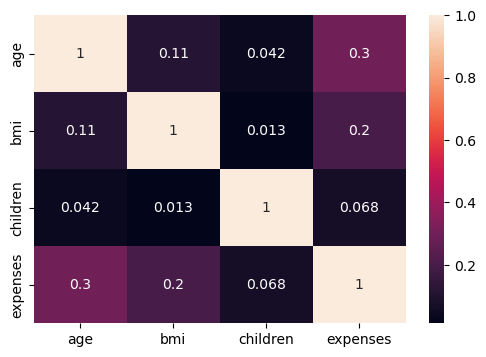

In [6]:
plt.figure(figsize=(6,4))
sns.heatmap(df.corr(numeric_only=True),annot=True)
plt.show()

<Figure size 300x300 with 0 Axes>

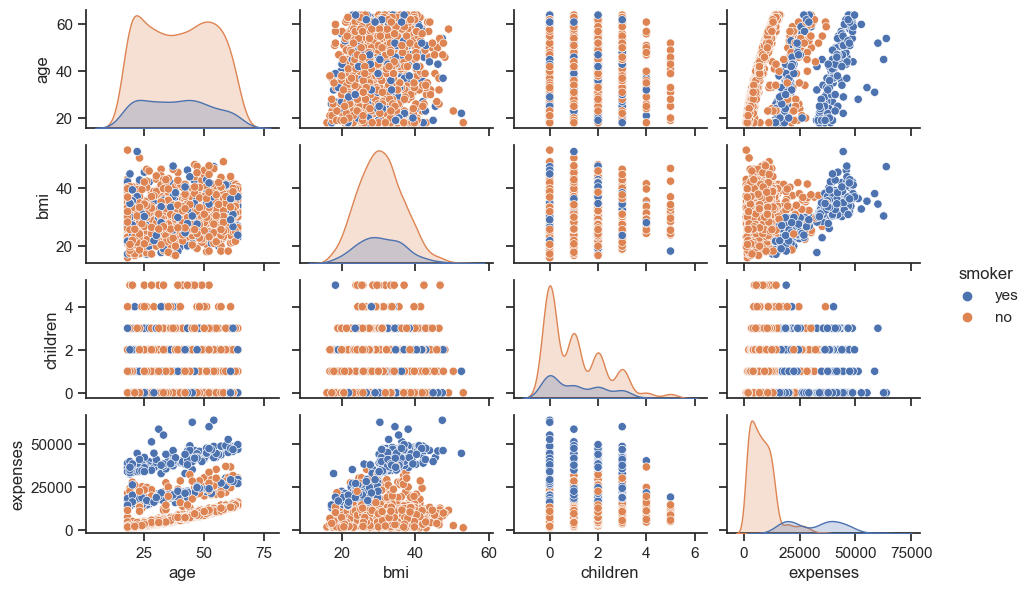

In [21]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="smoker")
plt.show()

#### Inference from the plot 
- 

<Figure size 300x300 with 0 Axes>

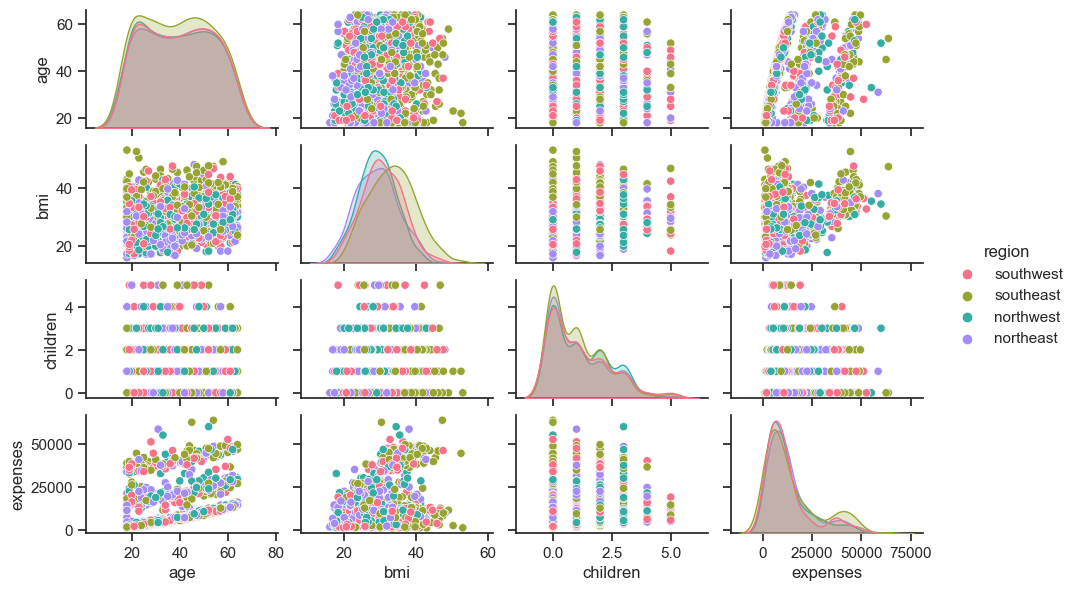

In [22]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="region",palette="husl")
plt.show()

#### Inference from the plot 
- 

<Figure size 300x300 with 0 Axes>

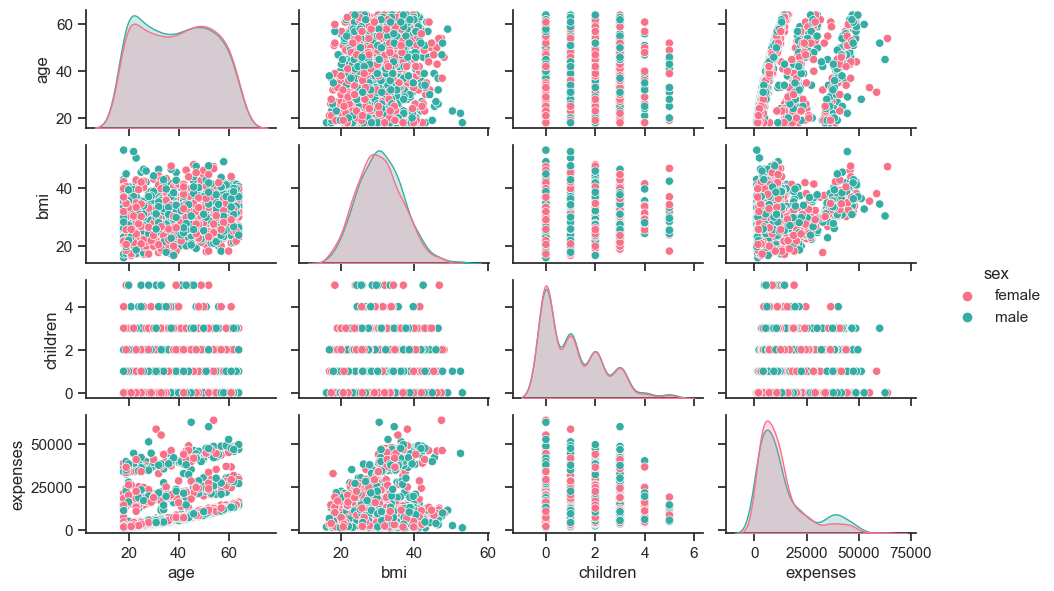

In [23]:
sns.set(style="ticks", color_codes=True)
plt.figure(figsize=(3,3))
g = sns.pairplot(df,height=1.5, aspect=1.6,hue="sex",palette="husl")
plt.show()

#### Inference from the plot 
- 

In [50]:
famd = FAMD(n_components =2, n_iter = 4)

### 02) Pre-processing the data 

In [31]:
'''Finding the number of categorical variables'''

check = (df.dtypes == 'object') 
categorical_var = list(check[check].index)

for cat_var in categorical_var:    
    unique_value = df[cat_var].unique()
    print (f'Number of categories in {cat_var} are: {len(unique_value)}, with categories as : {unique_value}')

Number of categories in sex are: 2, with categories as : ['female' 'male']
Number of categories in smoker are: 2, with categories as : ['yes' 'no']
Number of categories in region are: 4, with categories as : ['southwest' 'southeast' 'northwest' 'northeast']


In [45]:
check = df.dtypes!='object'

check[check]

age         True
bmi         True
children    True
expenses    True
dtype: bool

In [42]:
''' '''

onehot_enc = OneHotEncoder()
onehot_arr = onehot_enc.fit_transform(df[categorical_var]).toarray()
onehot_df = pd.DataFrame(onehot_arr, columns=onehot_enc.get_feature_names_out(categorical_var))

df_mod  = pd.concat([df.drop(categorical_var, axis=1), onehot_df], axis=1)

df_mod.head()


,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.8,1,1725.55,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.0,3,4449.46,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.7,0,21984.47,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.9,0,3866.86,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [39]:
onehot_enc.get_feature_names_out(categorical_var)

array(['sex_female', 'sex_male', 'smoker_no', 'smoker_yes',
       'region_northeast', 'region_northwest', 'region_southeast',
       'region_southwest'], dtype=object)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'expenses'], dtype='object')

(1338, 7)

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


list of categorical variables ['sex', 'smoker', 'region']
Number of varibale in region are: 2, there are ['female' 'male']
Number of varibale in region are: 2, there are ['yes' 'no']
Number of varibale in region are: 4, there are ['southwest' 'southeast' 'northwest' 'northeast']


### Pre-processing 

Here, we convert the categorical variables into one-hot encoding as there are no ordinal relationship (no natural order) between the data. 

## Clustering 

### Partitional clustering

### Data prepration 

In [102]:
#viweing current dataset
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


In [103]:
# convert catagorical variable into numerical 

# Import library


# Finding the cloumn in dataset which having catagorical value 

cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert categorical variables to one-hot encoding

onehot_enc = OneHotEncoder()

onehot_arr = onehot_enc.fit_transform(df[cat_cols]).toarray()
onehot_df = pd.DataFrame(onehot_arr, columns=onehot_enc.get_feature_names_out(cat_cols))

# Merge one-hot encoding dataframe with the original dataframe and droping the column with catagorical data
df = pd.concat([df.drop(cat_cols, axis=1), onehot_df], axis=1)

df.head()


,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.9,0,16884.92,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,33.8,1,1725.55,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,33.0,3,4449.46,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,22.7,0,21984.47,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,28.9,0,3866.86,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


In [104]:
# checking dataset whether value are distubuted equally :

df.describe() 

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414,0.494768,0.505232,0.795217,0.204783,0.242152,0.242900,0.272048,0.242900
std,14.049960,6.098382,1.205493,12110.011240,0.500160,0.500160,0.403694,0.403694,0.428546,0.428995,0.445181,0.428995
min,18.000000,16.000000,0.000000,1121.870000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,26.300000,0.000000,4740.287500,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,30.400000,1.000000,9382.030000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,34.700000,2.000000,16639.915000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,64.000000,53.100000,5.000000,63770.430000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [105]:
# Min and Max of each variable are vary in different range, therefore we normalizing  the variable 4

#Import library 
from sklearn.preprocessing import MinMaxScaler

# Select the numerical columns
num_cols = df[['age', 'bmi', 'children', 'expenses']]

# Standardize the numerical variables

scaler = MinMaxScaler()
num_cols_std = scaler.fit_transform(num_cols)

# Convert the standardized variables to a DataFrame
num_cols_std_df = pd.DataFrame(num_cols_std, columns=num_cols.columns)


df= pd.concat([num_cols_std_df, onehot_df], axis=1)


df

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,0.021739,0.320755,0.0,0.251611,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.000000,0.479784,0.2,0.009636,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.217391,0.458221,0.6,0.053115,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.326087,0.180593,0.0,0.333010,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0.304348,0.347709,0.0,0.043816,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.695652,0.404313,0.6,0.151299,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,0.000000,0.428571,0.0,0.017305,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,0.000000,0.563342,0.0,0.008108,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,0.065217,0.264151,0.0,0.014144,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [106]:
# Again checking dataset whether value are distubuted equally :

df.describe()

,age,bmi,children,expenses,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,0.461022,0.395296,0.218984,0.193916,0.494768,0.505232,0.795217,0.204783,0.242152,0.242900,0.272048,0.242900
std,0.305434,0.164377,0.241099,0.193301,0.500160,0.500160,0.403694,0.403694,0.428546,0.428995,0.445181,0.428995
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.195652,0.277628,0.000000,0.057757,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.456522,0.388140,0.200000,0.131849,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.717391,0.504043,0.400000,0.247700,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
df.to_csv('Data_set_cluster.csv', index=False)


### we are perfroming clustering for different case scanrio

#### case 1: Age and Medcial expenses 

In [108]:
# case 1 Age and medical expenses term it as (AM)

#import libraries 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


#select the columns we need perform clustering 

ae=df[['age','expenses']]

ae.head()

,age,expenses
0,0.021739,0.251611
1,0.000000,0.009636
2,0.217391,0.053115
3,0.326087,0.333010
4,0.304348,0.043816


##### step 1: Finding the k vlaue using elbow method

The elbow method is a way to determine the best number of clusters for unsupervised machine learning algorithms like clustering. It works by plotting the within-cluster sum of squares (WSS) against the number of clusters and finding the point where the rate of reduction of WSS levels off. This point is called the "elbow" or "knee". 

The WSS is a measure of how close each data point is to its assigned cluster center. When there are too few clusters, the WSS is high because the data points are far from their centers. As the number of clusters increases, the WSS decreases until it reaches a point where adding more clusters doesn't significantly improve it.



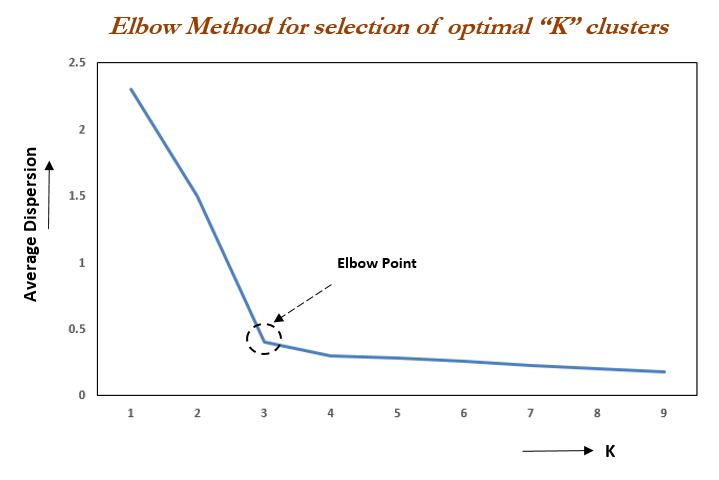
 
  To use the elbow method, 

*  choose the number of clusters to evaluate 
*  calculate the WSS for each number of clusters, 
*  plot the results, and
*  select the number of clusters at the elbow point.


 Keep in mind that the elbow method is not always accurate, and other techniques like silhouette analysis may be necessary to determine the optimal number of clusters.

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

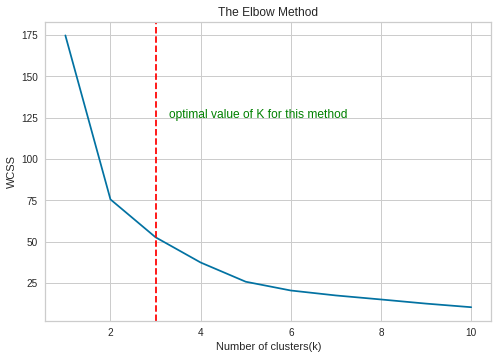

,k-value,wcss_value
0,1,174.685796
1,2,75.573180
2,3,52.690098
3,4,37.432199
4,5,25.817273
5,6,20.512755
6,7,17.518125
7,8,15.094154
8,9,12.589495
9,10,10.414786


In [109]:

wcss =[] # create an empty list to store the within cluster sum of square (wcss)values

# start iterating for different k value 

for k in range(1,11):
  # cluster the data using k means --> here we selecting random k value by using "kmeans++ method"
  # using the random state to make program consistency, even if we change the value(it can be any number)
  
  kmeans=KMeans(n_clusters=k,init='k-means++',random_state=21) 

  #fit and predict the cluster number for each data 
  kmeans.fit_predict(ae) 

  #calcaultate the within-cluster sum of square and append to the wcss list 
  wcss.append(kmeans.inertia_)

#plot the wcss values against k value (to get elbow curve)

plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters(k)')
plt.ylabel('WCSS')
plt.axvline(x=3, color='red', linestyle='--',label="3") #just for refernce to find optimal k and it will change depand upon k value 
plt.text(3.3, 125, 'optimal value of K for this method', color='green')
plt.show()

#Display the wcss value for each cluster

wcss_value=pd.DataFrame({'k-value':range(1,11),'wcss_value':wcss})
wcss_value


##### step 2: Finding the optimum value of k by other methods

Finding the optimal number of clusters in unsupervised machine learning algorithms like clustering is an important task as it directly affects the quality of the results. 

###### step 2(a): using the silhouette method

The Silhouette Coefficient for a point i is defined as follows:


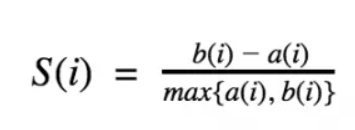

where b(i) is the smallest average distance of point i to all points in any other cluster and a(i) is the average distance of i from all other points in its cluster. For example, if we have only 3 clusters A,B and C and i belongs to cluster C, then b(i) is calculated by measuring the average distance of i from every point in cluster A, the average distance of i from every point in cluster B and taking the smallest resulting value. The Silhouette Coefficient for the dataset is the average of the Silhouette Coefficient of individual points.

The Silhouette Coefficient tells us if individual points are correctly assigned to their clusters. We can use the following thumb rules while using Silhouette Coefficient:

S(i) close to 0 means that the point is between two clusters
If it is closer to -1, then we would be better off assigning it to the other clusters
If S(i) is close to 1, then the point belongs to the ‘correct’ cluster

**To find optiaml number of cluster :**

Identify the value of k that corresponds to the highest average silhouette score. This is the optimal number of clusters.

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

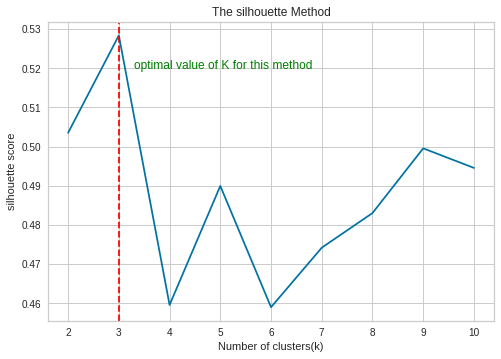

,k-value,silhouette_value
0,2,0.503503
1,3,0.528352
2,4,0.459575
3,5,0.489946
4,6,0.458998
5,7,0.474185
6,8,0.483024
7,9,0.499536
8,10,0.494542


In [110]:
# step 2(a)(i): using the silhouette method --> simple graph 

#import library
from sklearn.metrics  import silhouette_score

silhouette_values =[] # create an empty list to store the silhouette score for different values

# start iterating for different k value 

for k in range(2,11): # for sihouette we need atleast two cluster for comparision so we starting with 2 

  # cluster the data using k means --> here we selecting random k value by using "kmeans++ method"
  # using the random state to make program consistency, even if we change the value(it can be any number)
  
  kmeans=KMeans(n_clusters=k,init='k-means++',random_state=21) 

  #fit and predict the cluster number for each data 
  cluster=kmeans.fit_predict(ae) 

  #calcaultate the silhouette score for each cluster and append to silhouette_score the list 
  score=silhouette_score(ae,cluster) # ---> this kind of ae(a(i)) and cluster (b(i))
  silhouette_values.append(score)

#plot the silhouette score values against k value 

plt.plot(range(2,11),silhouette_values)
plt.title('The silhouette Method')
plt.xlabel('Number of clusters(k)')
plt.ylabel('silhouette score')
plt.axvline(x=3, color='red', linestyle='--',label="3") #just for refernce to find optimal k and it will change depand upon k value 
plt.text(3.3, 0.52, 'optimal value of K for this method', color='green')
plt.show()

#Display the  silhouette score for each cluster

silhouette_value=pd.DataFrame({'k-value':range(2,11),'silhouette_value':silhouette_values})
silhouette_value

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 2 The average silhouette_score is : 0.5035027657484972


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 3 The average silhouette_score is : 0.528352173907288


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 4 The average silhouette_score is : 0.45957458026389636


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 5 The average silhouette_score is : 0.48994589347966766


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 6 The average silhouette_score is : 0.4589978986562512


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.47418461296255815


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 8 The average silhouette_score is : 0.4830238495257916


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 9 The average silhouette_score is : 0.49953573355130854


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.4945419795607645


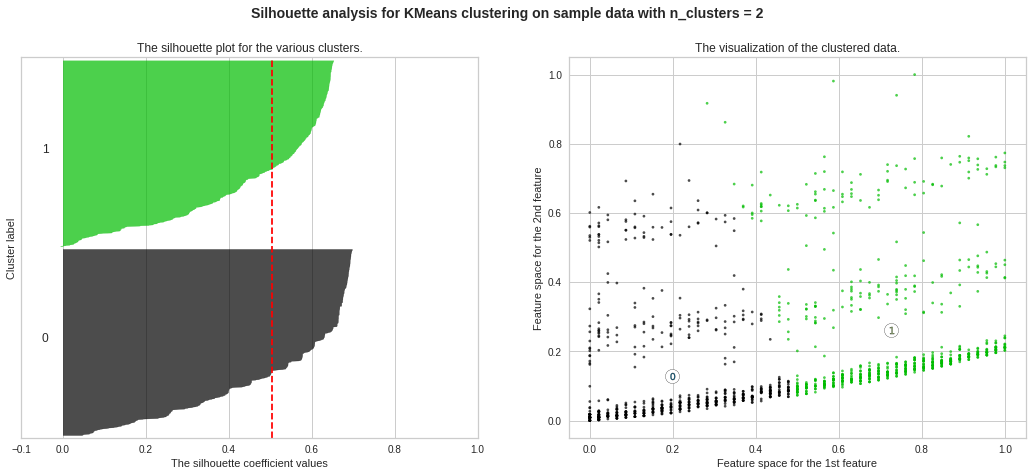

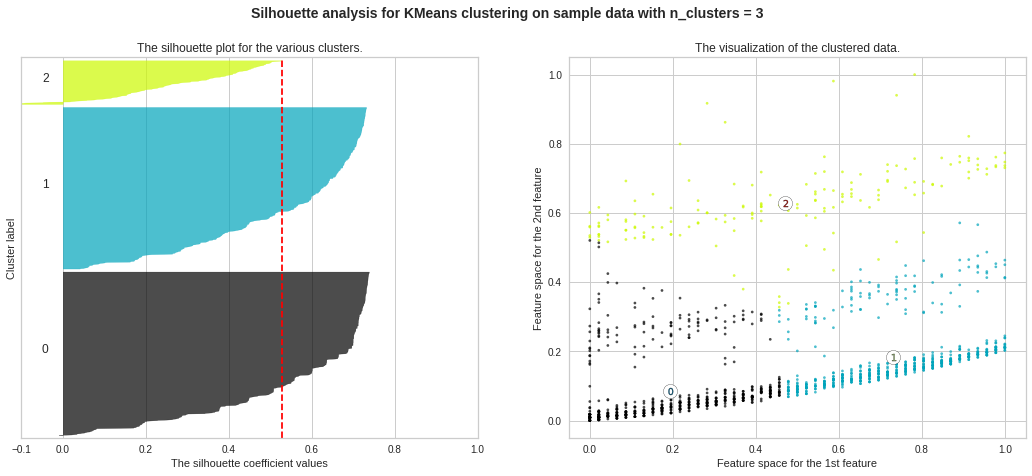

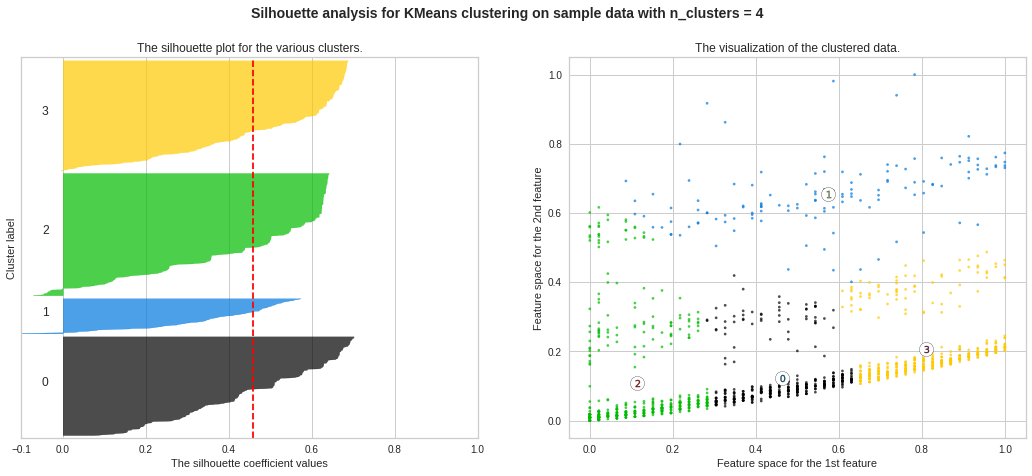

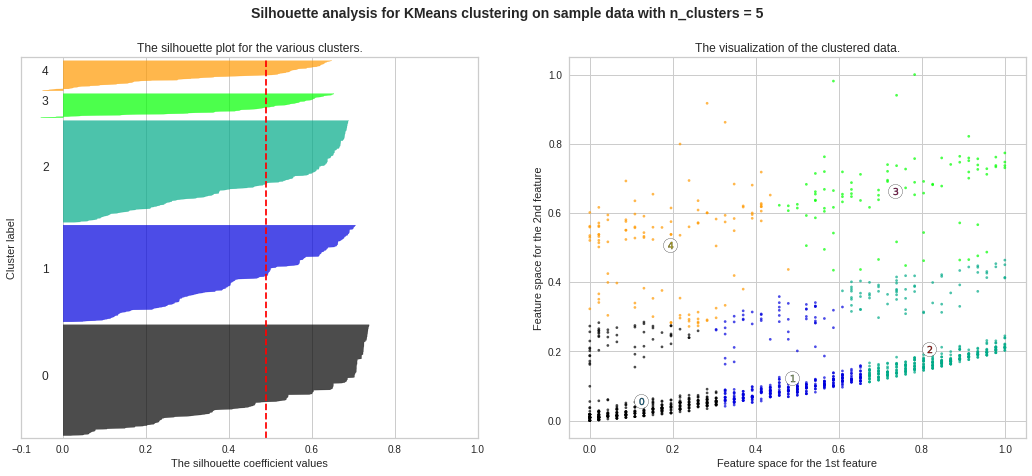

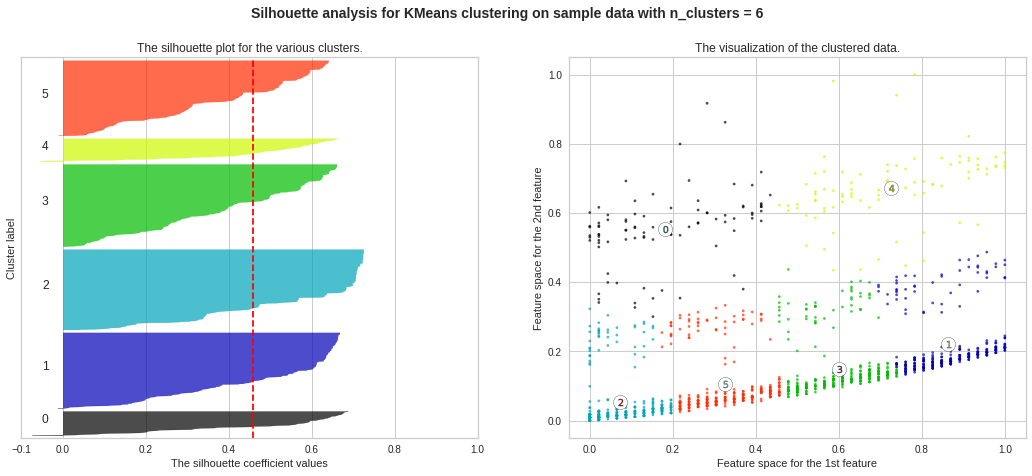

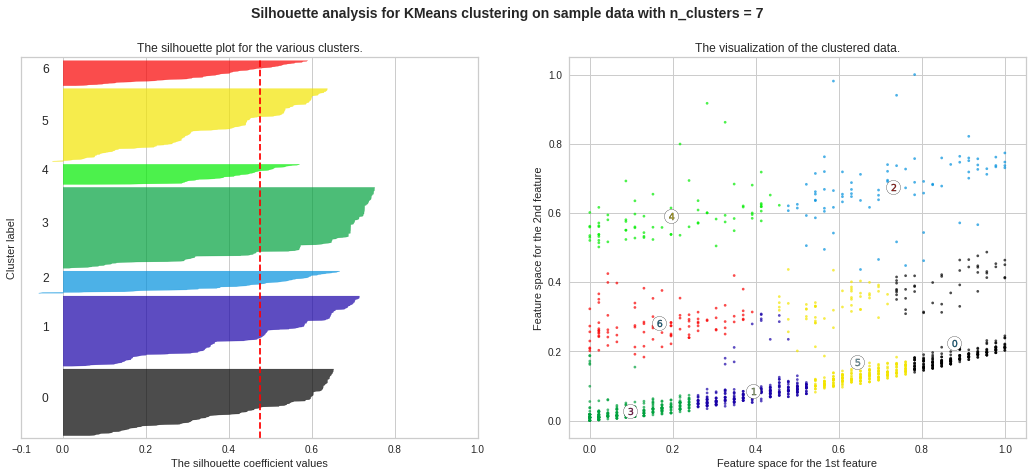

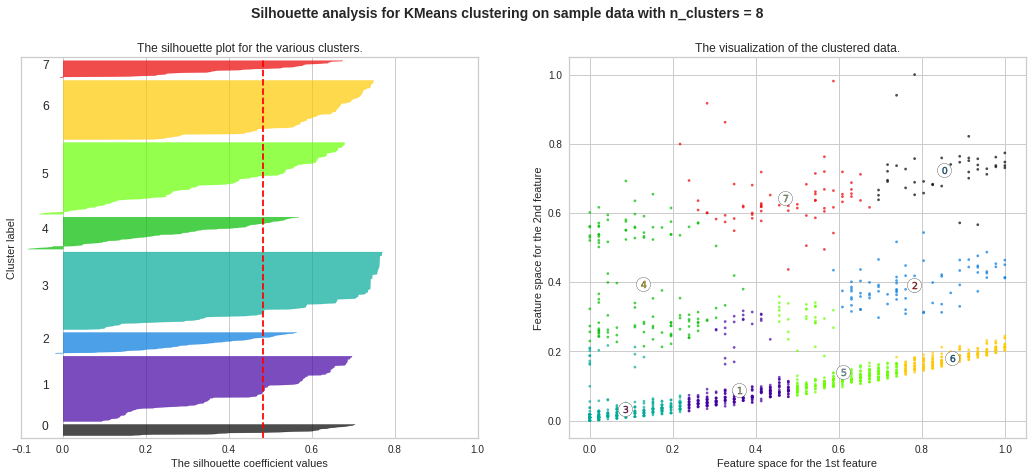

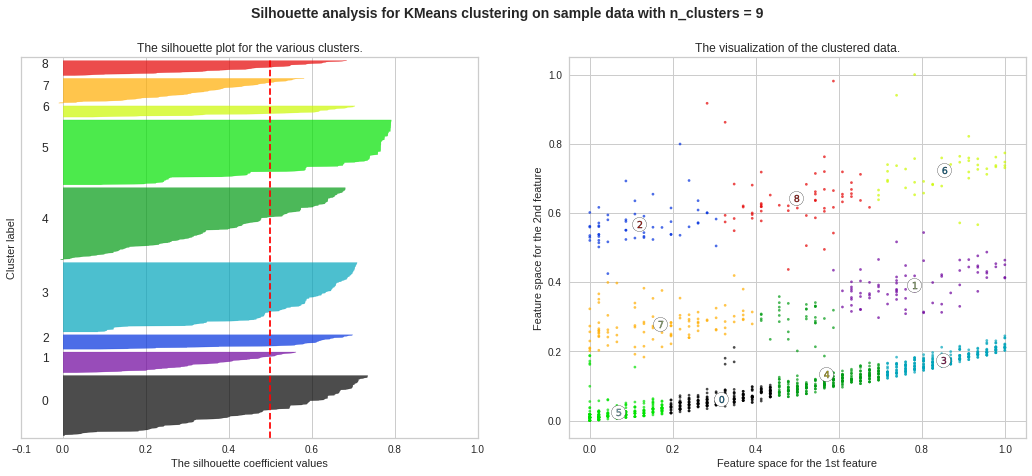

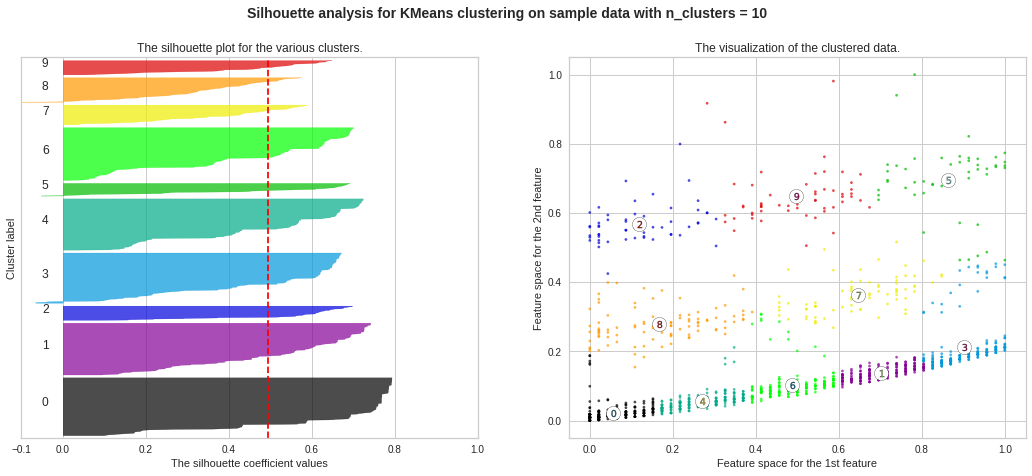

In [111]:
# step 2(a)(ii): using the silhouette method --> complete analysis of silhouette score using some visulization technique (graph)to measure each clsuter range [-1, 1].

'''Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters.
 A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and 
 negative values indicate that those samples might have been assigned to the wrong cluster.'''

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


for n_clusters in range(2,11):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(ae) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++',random_state=21)
    cluster_labels = clusterer.fit_predict(ae)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(ae, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(ae, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(ae.iloc[:, 0], ae.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


###### step 2(b): gap method

**The optimal number of clusters is where the gap between the observed and expected WSS is maximum.**

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(2.3, 0.65, 'optimal value of K for this method')

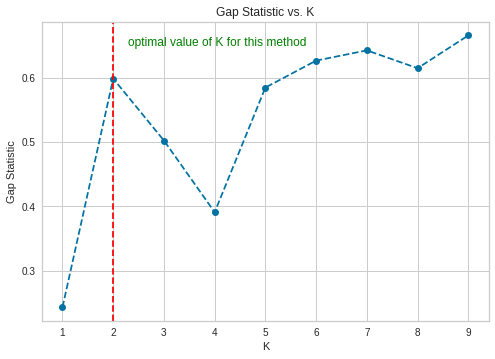

In [112]:
# Gap Statistic for K means
def optimalK(data, nrefs=5, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(n_clusters=k, init='k-means++', random_state=21)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(n_clusters=k, init='k-means++', random_state=21)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)
score_g, df = optimalK(ae, nrefs=5, maxClusters=10)
plt.plot(df['clusterCount'], df['gap'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Gap Statistic');
plt.title('Gap Statistic vs. K');
plt.axvline(x=2, color='red', linestyle='--',label="3") #just for refernce to find optimal k and it will change depand upon k value 
plt.text(2.3, 0.65, 'optimal value of K for this method', color='green')

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

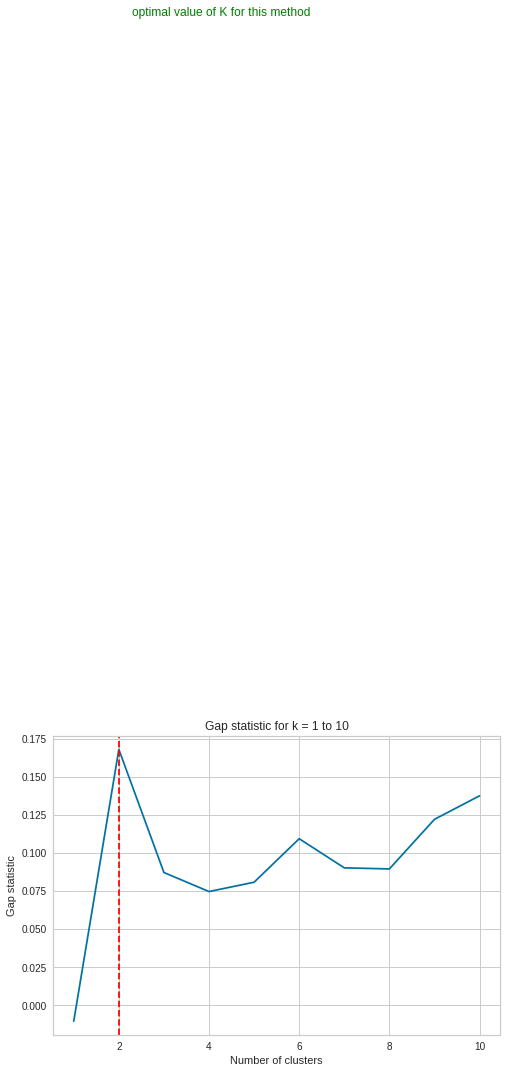

Optimal number of clusters: 2


In [113]:
# Calculate the gap statistic for a range of k values(method_2)
def gap_statistic(data, k_max):
    # Calculate the reference distribution of data by generating uniform data with same range and number of samples
    data_ref = np.random.rand(*data.shape)
    data_range = data.max(axis=0) - data.min(axis=0)
    data_ref = data_ref * data_range + data.min(axis=0)

    # Calculate the within-cluster dispersion for the reference data
    ref_disp = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=21).fit(data_ref)
        ref_disp.append(kmeans.inertia_)

    # Calculate the within-cluster dispersion for the actual data for a range of k values
    disp = []
    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=21).fit(data)
        disp.append(kmeans.inertia_)

    # Calculate the gap statistic for each k
    gap = np.log(ref_disp) - np.log(disp)

    # Calculate the standard error for each k
    se = np.sqrt(1 + 1 / len(data)) * np.std(np.log(ref_disp))
    se = se * np.sqrt(1 + 1 / len(data))

    # Calculate the optimal k based on the maximum gap statistic
    k_opt = np.argmax(gap) + 1

    # Plot the gap statistic for each k
    plt.plot(range(1, k_max + 1), gap)
    plt.xlabel('Number of clusters')
    plt.ylabel('Gap statistic')
    plt.title('Gap statistic for k = 1 to ' + str(k_max))
    plt.axvline(x=2, color='red', linestyle='--',label="3") #just for refernce to find optimal k and it will change depand upon k value 
    plt.text(2.3, 0.65, 'optimal value of K for this method', color='green')
    plt.show()
 
    return se,k_opt,gap

# Reshape the autoencoder output to a 2-dimensional array
ae_new= ae.values.reshape(-1, 1)

se,k_opt,gap = gap_statistic(ae_new,10)
print('Optimal number of clusters:', k_opt)



###### step 2(c): Calinski Harabasz Score for K means

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

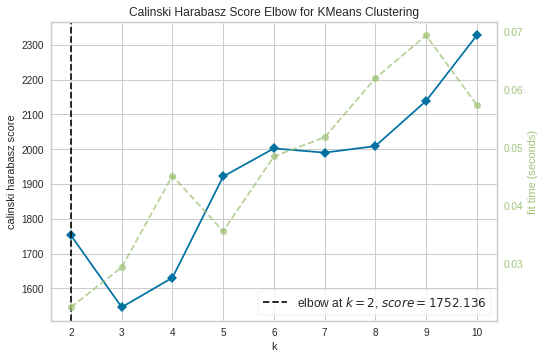

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [114]:
# Calinski Harabasz Score for K means
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(n_clusters=k, init='k-means++', random_state=21)
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,11),metric='calinski_harabasz',timings= True)
visualizer.fit(ae)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


###### step 2(d):  Davies Bouldin score for K means

** A lower DBI indicates better clustering.**

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(5.3, 0.8, 'optimal value of K for this method')

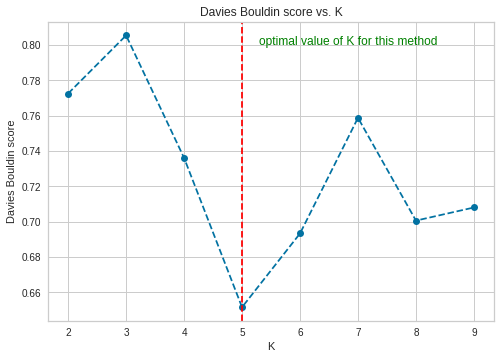

In [115]:
# Davies Bouldin score for K means
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, k):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=k,init='k-means++', random_state=21)
    # Then fit the model to your data using the fit method
    model = kmeans.fit_predict(ae)
    
    # Calculate Davies Bouldin score
    score = davies_bouldin_score(ae, model)
    
    return score

scores = []
centers = list(range(2,10))
for center in centers:
    scores.append(get_kmeans_score(ae, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Davies Bouldin score');
plt.title('Davies Bouldin score vs. K');
plt.axvline(x=5, color='red', linestyle='--',label="3") #just for refernce to find optimal k and it will change depand upon k value 
plt.text(5.3, 0.8, 'optimal value of K for this method', color='green')

###### step 2(e): AIC and BIC values

** The lower the value is, the better the model is.**

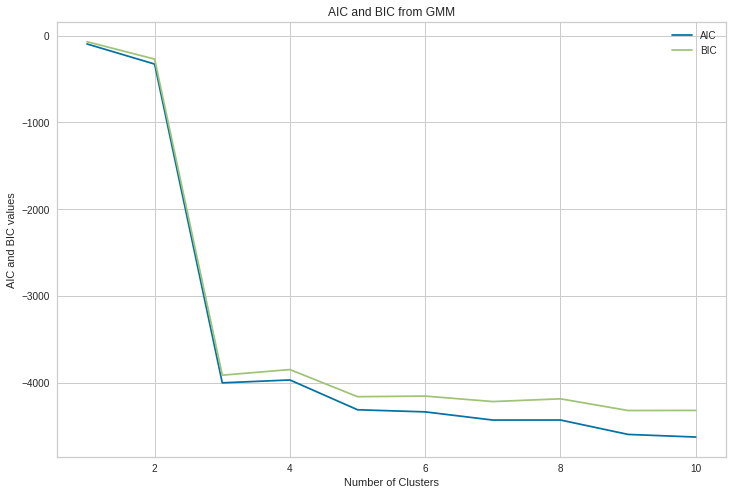

,AIC,BIC
1,-94.978531,-68.983875
2,-327.053392,-269.865148
3,-4000.635443,-3912.253612
4,-3967.409304,-3847.833885
5,-4311.060453,-4160.291447
6,-4335.233969,-4153.271375
7,-4429.620630,-4216.464449
8,-4429.079820,-4184.730051
9,-4595.116985,-4319.573629
10,-4625.153905,-4318.416962


In [116]:
from sklearn.mixture import GaussianMixture

# Create empty dictionary for AIC and BIC values
aic_score = {} 
bic_score = {}

# Loop through different number of clusters
for i in range(1,11): 
  # Create Gaussian Mixture Model
  gmm = GaussianMixture(n_components=i, random_state=21)
  
  # Fit the model to your data
  gmm.fit(ae)
  
  # Get AIC score for the model
  aic_score[i] = gmm.aic(ae)
  
  # Get BIC score for the model
  bic_score[i] = gmm.bic(ae)

# Visualization
plt.figure(figsize=(12,8))
plt.plot(list(aic_score.keys()),list(aic_score.values()), label='AIC')
plt.plot(list(bic_score.keys()),list(bic_score.values()), label='BIC')
plt.legend(loc='best')
plt.title('AIC and BIC from GMM')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC and BIC values')
plt.show()


# Create a pandas dataframe with the AIC and BIC scores
df = pd.DataFrame({'AIC': aic_score, 'BIC': bic_score})

# Print the dataframe
df

###### step 2(f): Dendogram for Heirarchical Clustering
** the optimal number of clusters (k) using the dendrogram, we can look for the longest vertical line that does not intersect any of the horizontal lines**

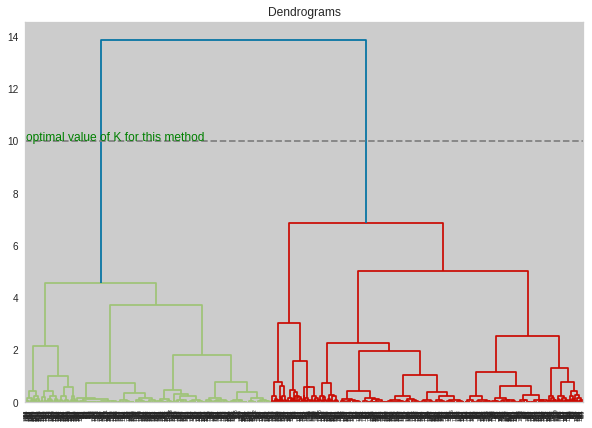

In [117]:
# Dendogram for Heirarchical Clustering
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot
pyplot.figure(figsize=(10, 7))  
pyplot.title("Dendrograms")  
dendogram = shc.dendrogram(shc.linkage(ae, method='ward'))
# Find the longest vertical line that doesn't intersect any horizontal line
max_d = 10  # Maximum distance between clusters
plt.axhline(y=max_d, c='gray', linestyle='--')
plt.text(5.3, 10, 'optimal value of K for this method', color='green')
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-121-89aca3a51180>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ae['cluster'] = labels


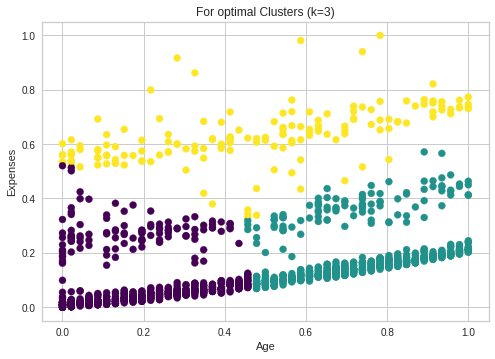

   Cluster  Count
0        0    593
1        1    586
2        2    159


,age,expenses,cluster
0,0.021739,0.251611,0
1,0.000000,0.009636,0
2,0.217391,0.053115,0
3,0.326087,0.333010,0
4,0.304348,0.043816,0
...,...,...,...
1333,0.695652,0.151299,1
1334,0.000000,0.017305,0
1335,0.000000,0.008108,0
1336,0.065217,0.014144,0


In [121]:
# Cluster the data using the optimal number of clusters
kmeans = KMeans(n_clusters=3, random_state=21)
labels = kmeans.fit_predict(ae)

# Add the cluster labels to the original dataframe
ae['cluster'] = labels

# Create a scatter plot of the data colored by cluster
plt.scatter(ae['age'], ae['expenses'], c=ae['cluster'], cmap='viridis')
plt.title(f'For optimal Clusters (k={3})')
plt.xlabel('Age')
plt.ylabel('Expenses')
plt.show()

# Display the number of customers in each cluster
cluster_counts = ae['cluster'].value_counts().sort_index()
cluster_table = pd.DataFrame({'Cluster': cluster_counts.index, 'Count': cluster_counts.values})
print(cluster_table)
ae

In [122]:
centroids=kmeans.cluster_centers_
pd.DataFrame(centroids,columns=ae.columns).T

,0,1,2
age,1.927561e-01,0.729485,0.472108
expenses,8.612343e-02,0.184884,0.629223
cluster,-3.108624e-15,1.000000,2.000000
